## 0. Preparación del entorno
Para empezar, lo primero que vamos a hacer va a ser preparar el entorno en el que se van a hacer las ejecuciones, de donde el programa tiene que cargar las imágenes y las máscaras de las nebulosas planetarias y donde va a guardar los resultados obtenidos.

In [37]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
# route = "C:\\Users\\Lucan\\OneDrive - Universidade da Coruña\\Escritorio\\4_GCEID\\TFG\\test\\PNe_segmentation"
route = os.getcwd() #+ "/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print("\nEl directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print("\nContenido del directorio actual:")
for file in files:
    print("\t",file)


Vamos a cambiar el directorio de trabajo

El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation

Contenido del directorio actual:
	 commands.txt
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 launch_jupyter.sh
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb


### 0.1. Carga de las imágenes junto a sus máscaras


Vamos a hacer una prueba de como cargaríamos una máscara y contorno junto con la imagen a la que pertenece. Pero antes vamos a realizar ciertas operaciones para tener almacenados y clasificados todos los archivos que tenemos disponibles.

In [38]:
# Listamos el contenido del directorio de las máscaras
# masks_directory = "C:\\Users\\Lucan\\OneDrive - Universidade da Coruña\\Escritorio\\4_GCEID\\TFG\\test\\PNe_segmentation\\masks"
masks_directory = os.getcwd() + "/masks"
masksFiles = os.listdir(masks_directory)
masks_files = [file for file in masksFiles if file.endswith(".png")]

# data_directory = "C:\\Users\\Lucan\\OneDrive - Universidade da Coruña\\Escritorio\\4_GCEID\\TFG\\test\\PNe_segmentation\\data"
data_directory = os.getcwd() + "/data"
dataFiles = os.listdir(data_directory)
data_files = [file for file in dataFiles if file.endswith(".fits")]

Creamos un diccionario en el que las claves sean el nombre identificador de la nebulosa y el valor sea una lista con las máscaras y contornos disponibles de esa nebulosa.

In [39]:
masks_dict = {}

for mask_file in masks_files:
    nebula_name = mask_file.split("_")[:-1]
    nebula_name = "_".join(nebula_name)
    if masks_dict.get(nebula_name) is None:
        masks_dict[nebula_name] = [mask_file]
    else: 
        masks_dict[nebula_name].append(mask_file)

masks_dict


{'A13': ['A13_contour.png'],
 'A14': ['A14_contour.png', 'A14_mask.png'],
 'A16': ['A16_contour.png'],
 'A18': ['A18_contour.png', 'A18_mask.png'],
 'A19': ['A19_contour.png', 'A19_mask.png'],
 'A24': ['A24_contour.png', 'A24_mask.png'],
 'A2': ['A2_contour.png', 'A2_mask.png'],
 'A30': ['A30_contour.png', 'A30_mask.png'],
 'A39': ['A39_contour.png', 'A39_mask.png'],
 'A3': ['A3_contour.png'],
 'A43': ['A43_contour.png', 'A43_mask.png'],
 'A46': ['A46_contour.png', 'A46_mask.png'],
 'A4': ['A4_contour.png'],
 'A50': ['A50_contour.png', 'A50_mask.png'],
 'A52': ['A52_contour.png', 'A52_mask.png'],
 'A54': ['A54_contour.png', 'A54_mask.png'],
 'A57': ['A57_contour.png', 'A57_mask.png'],
 'A58': ['A58_contour.png', 'A58_mask.png'],
 'A63': ['A63_contour.png', 'A63_mask.png'],
 'A68': ['A68_contour.png', 'A68_mask.png'],
 'A70': ['A70_contour.png', 'A70_mask.png'],
 'A71': ['A71_contour.png', 'A71_mask.png'],
 'A72': ['A72_contour.png', 'A72_mask.png'],
 'A73': ['A73_contour.png'],
 'A75':

Comprobamos que todas las máscaras/contornos disponibles se han asignado a una nebulosa

In [40]:
masks_dict_count = sum(len(files) for files in masks_dict.values())
masks_files_count = len(masks_files)

if masks_dict_count == masks_files_count:
    print("The number of files in masks_dict is the same as the number of files in masks_files.")
else:
    print("The number of files in masks_dict is different from the number of files in masks_files.")
    
    files_not_in_data_dict = set(masks_files) - set(sum(masks_dict.values(), []))
    print("Files not in data_dict:", files_not_in_data_dict)


The number of files in masks_dict is the same as the number of files in masks_files.


Ahora creamos un diccionario similar al anterior, con las mismas claves, pero en los valores se van a guardar los archivos fits que se refieren a la nebulosa indicada.

In [41]:
import re
data_dict = {}

for nebula in masks_dict.keys():
    patron = re.compile(r'(?i)' + nebula + r'\D+.*')
    data_dict[nebula] = [file for file in data_files if patron.match(file)]

data_dict

{'A13': ['A13hcg.fits', 'A13o3cg.fits'],
 'A14': ['A14hac.fits',
  'A14hacee.fits',
  'A14hc.fits',
  'A14n2c.fits',
  'A14n2cee.fits',
  'A14ocg.fits'],
 'A16': ['A16_Hacc.fits', 'A16_occ.fits'],
 'A18': ['A18hc.fits', 'A18ogc.fits'],
 'A19': ['A19hg.fits', 'A19ocg.fits'],
 'A24': ['A24hgc.fits', 'A24ocg.fits'],
 'A2': ['A2hc.fits', 'A2oc.fits'],
 'A30': ['A30hc.fits', 'A30oc.fits'],
 'A39': ['A39hgc.fits', 'A39ocgc.fits', 'A39ocgce.fits'],
 'A3': ['A3hcg.fits', 'A3o3cg.fits'],
 'A43': ['A43hg.fits', 'A43og.fits'],
 'A46': ['A46hgc.fits', 'A46ogc.fits'],
 'A4': ['A4hc.fits', 'A4oc.fits'],
 'A50': ['A50h.fits', 'A50oc.fits'],
 'A52': ['A52hac.fits', 'A52o3c.fits'],
 'A54': ['A54hacg.fits', 'A54o3gc.fits'],
 'A57': ['A57Ha.fits',
  'A57Hac.fits',
  'A57Hace.fits',
  'A57o3.fits',
  'A57o3c.fits',
  'A57o3ce.fits'],
 'A58': ['A58blue.fits', 'A58hace.fits', 'A58n2ce.fits'],
 'A63': ['A63hac.fits', 'A63o3_badcg.fits'],
 'A68': ['A68hac.fits', 'A68o3c.fits'],
 'A70': ['A70hc.fits', 'A70oc.f

Comprobamos que todos los archivos fits disponibles se han asignado a una nebulosa

In [42]:
data_dict_count = sum(len(files) for files in data_dict.values())
data_files_count = len(data_files)

if data_dict_count == data_files_count:
    print("The number of files in data_dict is the same as the number of files in data_files.")
else:
    print("The number of files in data_dict is different from the number of files in data_files.")
    
    files_not_in_data_dict = set(data_files) - set(sum(data_dict.values(), []))
    print("Files not in data_dict:", files_not_in_data_dict)


The number of files in data_dict is the same as the number of files in data_files.


En este punto tenemos dos diccionarios con los cuales cargar los archivos facilmente y clasificados por el nombre identificador de la nebulosa.
Ahora sí, vamos a cargar todos los canales disponibles de una nebulosa junto a su contorno y máscara (si tiene).

In [43]:
from astropy.io import fits
import imageio as io
import numpy as np
def cargar_canales_nebulosa(nebula, data_dict, masks_dict, data_directory, masks_directory, name_files:bool=False):
    data_files = data_dict[nebula]
    masks_files = masks_dict[nebula]
    data = {}
    masks = {}
    charge_files = {}
    
    for file in masks_files:
        key = file.split("_")[-1].split(".")[0]
        image = io.imread("masks/"+file)
        if len(image.shape) > 2:
            image = image[:,:,0]
        masks[key] = image
        
    for file in data_files:
        image = fits.getdata("data/"+file)
        image = np.flip(image, axis=0)
        if image.shape == masks['contour'].shape:
            key = file.replace(nebula, "").replace("_","")[0].lower()
            data[key] = image
            charge_files[key] = file
        # else:
        #     print(f"Error: {file} has a different shape than the masks.")
    if not name_files:
        return data, masks
    else:
        return data, masks, charge_files

En este punto, ya podríamos cargar todos los canales y máscaras que tenemos, pudiendo distinguir por nebulosa. Por ejemplo, en la siguiente celda de código vamos a cargar todos los canales de una nebulosa en específico junto a sus máscaras.

In [44]:
data_dict['K3_72']

['K3_72hac.fits',
 'K3_72hace.fits',
 'K3_72hc.fits',
 'K3_72n2c.fits',
 'K3_72n2ce.fits',
 'K3_72n2ce_med2.fits',
 'K3_72oc.fits']

In [45]:
canales, mascaras = cargar_canales_nebulosa("K3_72", data_dict, masks_dict, data_directory, masks_directory)

/tmp/ipykernel_1196505/1148693601.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread("masks/"+file)


Vamos a analizar como son las imagenes obtenidas, sus valores mínimos y máximos, sus dimensiones, etc.

In [46]:
def imprimir_info_imagen(image, title):
    min_value = np.min(image)
    max_value = np.max(image)
    dimensions = image.shape
    null_values = np.isnan(image).sum()
    print(title)
    print(f"Minimum value: {min_value}")
    print(f"Maximum value: {max_value}")
    print(f"Null values: {null_values}")
    print(f"Dimensions: {dimensions}\n")

In [47]:
# Analyze canales' images
for key, channel in canales.items():
    imprimir_info_imagen(channel, f"Channel {key}:")

# Analyze mascaras' images
for key, mask in mascaras.items():
    imprimir_info_imagen(mask, f"Mask {key}:")

Channel h:
Minimum value: -60.16081619262695
Maximum value: 62.67976760864258
Null values: 0
Dimensions: (984, 984)

Channel n:
Minimum value: -56.29856491088867
Maximum value: 688.9967041015625
Null values: 0
Dimensions: (984, 984)

Mask contour:
Minimum value: 1
Maximum value: 255
Null values: 0
Dimensions: (984, 984)



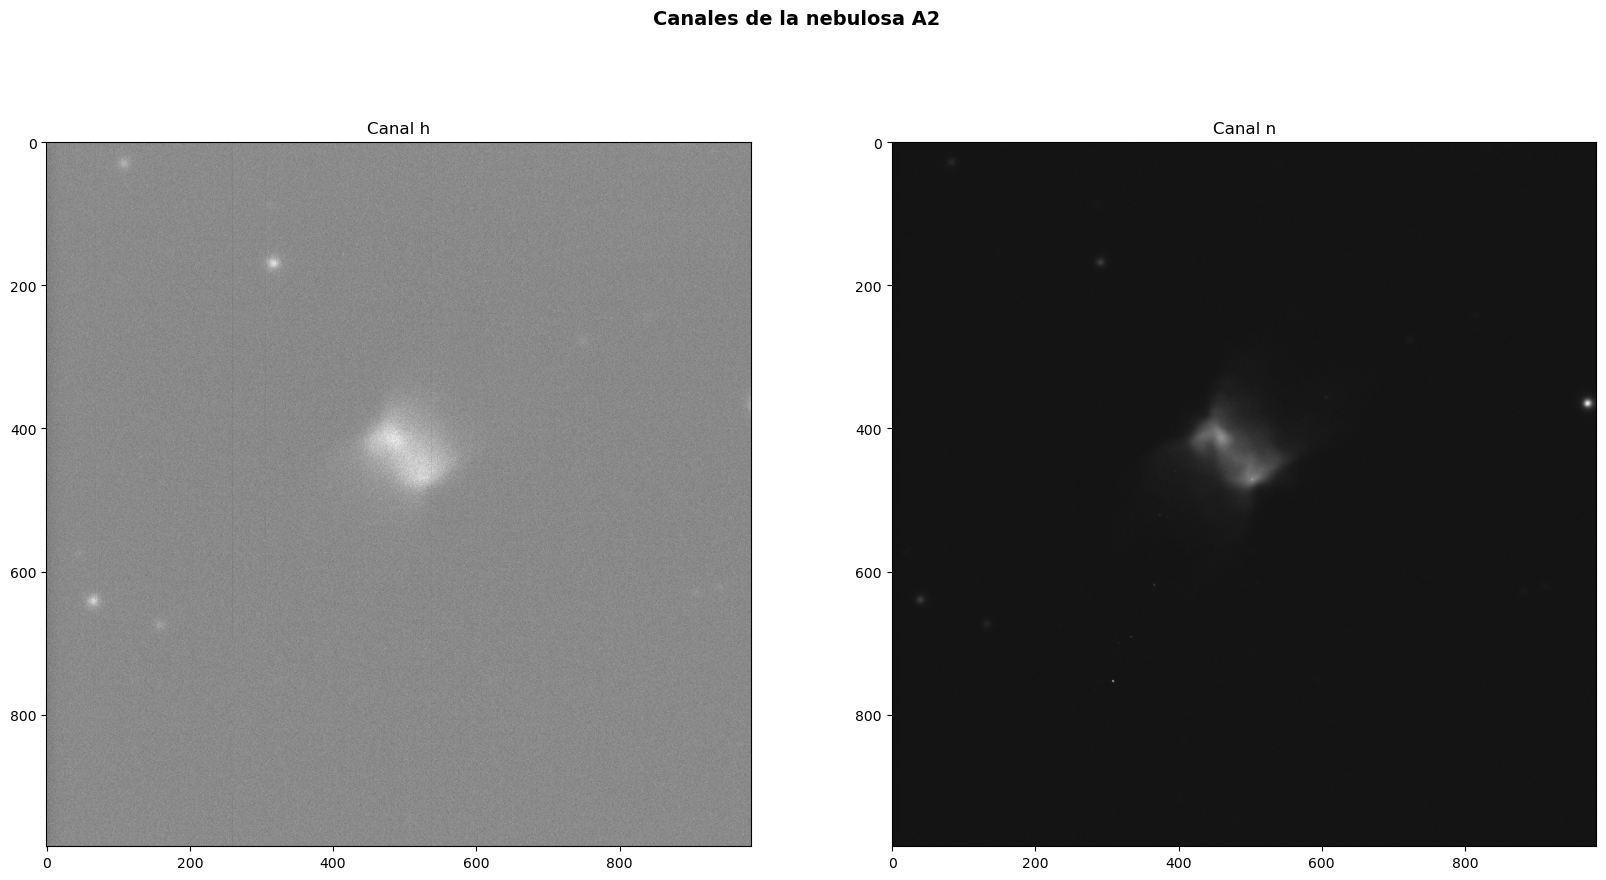

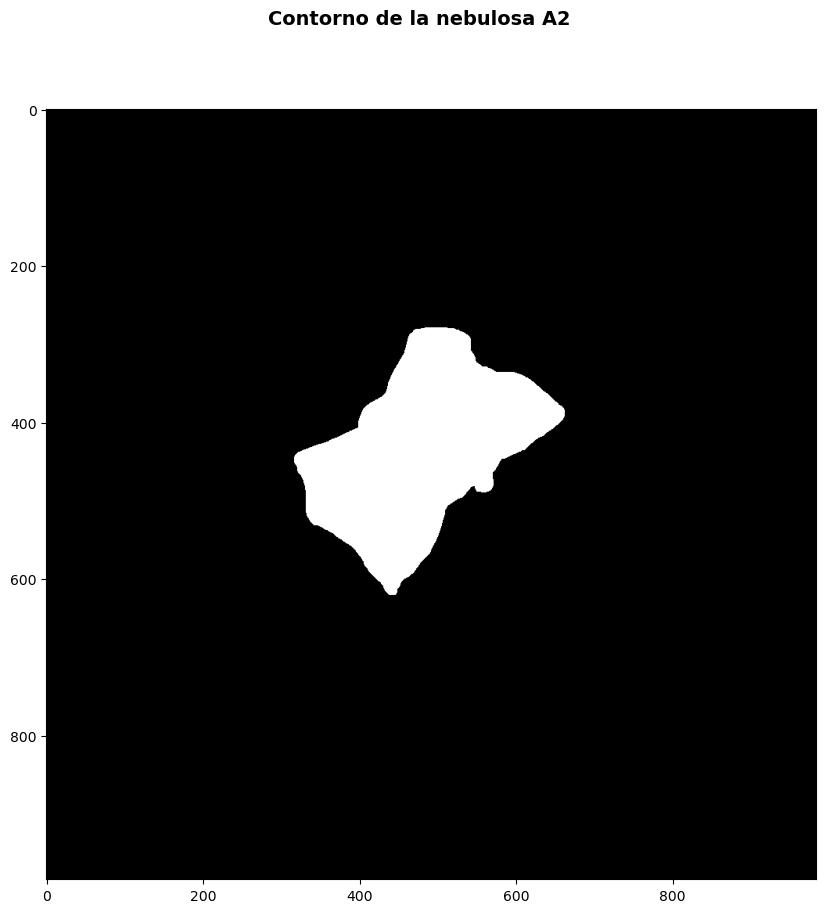

In [48]:
import matplotlib.pyplot as plt
num_images = len(canales)

fig, ax = plt.subplots(1, num_images, figsize=(10*num_images, 10))
fig.suptitle(f"Canales de la nebulosa A2", fontweight = 'bold', fontsize = 14)

for i, (key, channel) in enumerate(canales.items()):
    ax[i].imshow(channel, cmap = "gray")
    ax[i].set_title(f"Canal {key}")
fig.show()

if 'mask' in mascaras.keys():
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"Contorno y máscara de la nebulosa A2", fontweight = 'bold', fontsize = 14)

    ax[0].imshow(mascaras['contour'], cmap = "gray")
    ax[1].imshow(mascaras['mask'], cmap = "gray")
    fig.show()
else:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.suptitle(f"Contorno de la nebulosa A2", fontweight = 'bold', fontsize = 14)

    ax.imshow(mascaras['contour'], cmap = "gray")
    fig.show()

### 0.2. Preprocesado de los datos

Como parte del preprocesado inicial, vamos a hacer un estudio de cuales son los canales/filtros que comparten todas (o la mayoría de nebulosas) para así empezar a hacer pruebas con un conjunto de imágenes lo más homogéneo posible (para los canales).

In [49]:
for i in data_dict.keys():
    canales, mascaras = cargar_canales_nebulosa(i, data_dict, masks_dict, data_directory, masks_directory)
    if len(canales) != 2:
        print(i, len(canales))
    

/tmp/ipykernel_1196505/1148693601.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread("masks/"+file)


A58 3
A71 1
He1_1 3
He1_2 3
He1_3 3
He2_428 3
He2_429 3
He2_430 3
He2_432 3
He2_437 3
He2_447 3
He2_459 3
h2 1
Hu1_1 3
IC4593 3
KjPn3 3
K3_1 3
K3_2 3
K3_5 3
K3_7 3
K3_16 3
K3_18 3
K3_21 3
K3_24 3
K3_26 3
K3_36 3
K3_38 3
K3_45 3
K3_3 3
K3_53 3
K3_56 3
K3_57 3
K3_58 3
K3_61 3
K3_63 3
K3_64 3
K3_68 3
K3_76 3
K3_79 3
K3_80 3
K3_83 3
K3_84 3
K3_88 3
K3_90 3
K3_91 3
K3_93 3
K3_94 3
K4_55 3
KjPn1 3
M1_6 3
M1_9 3
M1_57 3
M1_59 3
M1_66 3
M1_72 3
M1_73 3
M1_74 3
M1_75 3
M1_78 3
M2_2 3
M2_40 3
M2_44 3
M2_46 3
M2_48 3
M2_49 3
M2_50 3
M3_28 3
M3_34 3
M3_35 3
M3_52 3
M3_55 3
M4_14 3
M4_18 3
MA2 3
MA3 3
Me1_1 3
NGC6720 3
NGC6852 3
NGC6881 3
NGC6886 3
PB9 3
PB10 3
PC19 3
PC20 3
PC23 3
PC24 3
Pe1_14 3
Pe1_15 3
Pe1_16 3
Pe1_17 3
Pe1_18 3
Pe1_20 3
Pe1_21 3
Sd1 3
TDC1 3
Vy2_3 3
YM16 1


En este punto se han eliminado algunas imágenes de nebulosas del conjunto de datos:
- A33: dimensiones descuadradas
- H3_75: dimensiones descuadradas 

Vamos a comprobar que las nebulosas tengan mínimo un canal en común y ver cual es:

In [50]:
cnt = {}
for i in data_dict.keys():
    canales, mascaras = cargar_canales_nebulosa(i, data_dict, masks_dict, data_directory, masks_directory)
    for key in canales.keys():
        if key in cnt.keys():
            cnt[key] += 1
        else:
            cnt[key] = 1
        
        if key == 'b':
            print(i, key, canales.keys())

print(cnt)
    
    

/tmp/ipykernel_1196505/1148693601.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread("masks/"+file)


A58 b dict_keys(['b', 'h', 'n'])
{'h': 215, 'o': 201, 'b': 1, 'n': 105, '.': 1}


Descartamos la nebulosa h2 debido a que no se no sabemos a que canal pertenece (creo que es una combinación en escala de grises de diferentes canales por como se describe en el .fits)

In [51]:
data_dict.pop('h2', None)

['h2.fits']

Como se puede observar, la mayoría de nebulosas tienen el canal 'h', por lo que nos vamos a quedar con todas las imágenes que contiene ese canal y vamos a empezar a trabajar con ellos.

In [52]:
new_data_dict = {}
for i in data_dict.keys():
    canales, mascaras, charge_files = cargar_canales_nebulosa(i, data_dict, masks_dict, data_directory, masks_directory, True)
    if 'h' in canales.keys():
        if 'n' in canales.keys() or 'o' in canales.keys() or 'b' in canales.keys():
            charge_files.pop('n', None)
            charge_files.pop('o', None)
            charge_files.pop('b', None)
        new_data_dict[i] = charge_files

print(f"El tamaño de data_dict es {len(data_dict)} y el tamaño de new_data_dict es {len(new_data_dict)}")

/tmp/ipykernel_1196505/1148693601.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = io.imread("masks/"+file)


El tamaño de data_dict es 215 y el tamaño de new_data_dict es 215


Vamos a crear el diccionario definitivo con los archivos que vamos a cargar. Para esta prueba inicial, vamos a cargar como máscara única el archivo _mask si la nebulosa lo tiene y si no cargaremos el _contour.

In [53]:
for nebula, files in new_data_dict.items():
    mask = [file for file in masks_dict[nebula] if 'contour' in file][0]
    if len(masks_dict[nebula]) > 1:
        mask = [file for file in masks_dict[nebula] if 'mask' in file][0]
    new_data_dict[nebula].update({'mask': mask})
# Mostramos un ejemplo para ver que todo ha ido correctamente
print(new_data_dict[nebula])

{'h': 'YM16hacg.fits', 'mask': 'YM16_contour.png'}


Vamos a transformarlo a un dataframe de pandas para poder exportarlo a .csv y más adelante no tener que volver a hacer todo el procedimiento, además trabajar con dataframes de pandas puede ser mucho más accesible y fácil de visualizar.

In [54]:
import pandas as pd
df = pd.DataFrame.from_dict(new_data_dict, orient='index')

# Quiero cargar el nombre de la nebulosa como una columna y cambiarle el nombre de index a name
df.reset_index(inplace=True)
df.rename(columns={'index':'name'}, inplace=True)
print(df.head())

# Guardar el dataframe en un archivo csv
df.to_csv("data_files_1c.csv", index=False)

  name              h             mask
0  A13    A13hcg.fits  A13_contour.png
1  A14     A14hc.fits     A14_mask.png
2  A16  A16_Hacc.fits  A16_contour.png
3  A18     A18hc.fits     A18_mask.png
4  A19     A19hg.fits     A19_mask.png


Llegados a este punto, a no ser que se amplie el dataset de imágenes, no vamos a tener que volver a ejecutar esta parte inicial.

## 0.3. División de los conjuntos train y test

Vamos a formar dos .csv a partir del principal (creado anteriormente), uno que solo tenga las nebulosas usadas para entrenamiento y otro que solo tenga las nebulosas para test. De este modo, cuando ampliamos el dataset con más nebulosas, solo tenemos que utilizar el 'dataset_info.csv' para que siempre las mismas imágenes se encuentren en entrenamiento y en test, para que a la hora de realizar las pruebas con los distintos algoritmos no haya 'contaminaciones'.

In [55]:
import pandas as pd
df_general = pd.read_csv("data_files_1c.csv")
df_info = pd.read_csv("dataset_info.csv", sep=';')

df_merged = pd.merge(df_general, df_info, on='name', how='left')

In [56]:
missing_rows = df_info[~df_info['name'].isin(df_general['name'])]
missing_rows

,name,complete_tag,simple_tag,set
9,A33,R,R,test


Hacemos las divisiones de train y de test

In [57]:
df_train = df_merged[df_merged['set'] == 'train']
df_test = df_merged[df_merged['set'] == 'test']

Comprobamos que la suma del número de filas de ambas particiones más las filas que se han perdido por el camino suman el número total de filas en df_info (nebulosas procesadas, aunque algunas se hayan perdido por el camino por diversas razones)

In [58]:
df_train.shape[0] + df_test.shape[0] + missing_rows.shape[0] == df_info.shape[0]

True

Guardamos en dos .csv distintos los conjuntos de train y de test, con sus etiquetas incluidas y todo

In [59]:
df_train = df_train.drop(columns=['set'])
df_test = df_test.drop(columns=['set'])

df_train.to_csv("data_files_1c_train.csv", index=False)
df_test.to_csv("data_files_1c_test.csv", index=False)